In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# from collections.abc import Sequence
from typing import Sequence
import torch
import numpy as np
import time

_SSM_NAME = "JackFram/llama-160m"
_LLM_NAME = 'openlm-research/open_llama_3b_v2'
device = "cuda"

assert torch.cuda.is_available()
tokenizer = AutoTokenizer.from_pretrained(_SSM_NAME)
ssm = AutoModelForCausalLM.from_pretrained(_SSM_NAME).cuda()
llm = AutoModelForCausalLM.from_pretrained(_LLM_NAME).cuda()


/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
def _create_token_tree(
    expansion_config: Sequence[int],
    prompt: str,
    tokenizer: AutoTokenizer,
    model: AutoModelForCausalLM,
):
    """Create token tree following Figure 3 in the paper.

    We don't need "real" tokens for our experiments - just
    random integers would work too - but might as well.

    Figure 3 illustrates the <k1, k2, ...> expansion approach they
    use to create token trees. We can use each of the top_k tokens from
    a single model to create the same tree structure.

    Args:
        expansion_config: A sequence of integers representing how much to
            branch at each generation step.
        prompt: Initial prompt.
        tokenizer: HF tokenizer.
        model: HF generative model.
    """
    assert expansion_config
    current_tree = tokenizer(prompt, return_tensors="pt").input_ids.cuda()
    for k in expansion_config:
        output = model.generate(
            current_tree,
            max_new_tokens=1,
            return_dict_in_generate=True,
            output_scores=True,
        )
        # Take the top_k tokens from the 1 generation step we've done
        top_k = torch.topk(output.scores[-1], k=k, dim=-1).indices.reshape(-1, 1)
        current_tree = torch.repeat_interleave(current_tree, k, dim=0)
        # Join the top_k tokens to the current tree
        current_tree = torch.cat((current_tree, top_k), dim=-1)

    return current_tree

In [3]:
def construct_tree_model_inputs(sequences):
    # input_1 = torch.unique(torch.flatten(sequences), sorted=False)
    flat = torch.flatten(sequences).tolist()
    unique = []
    for tok in flat:
        if tok not in unique:
            unique.append(tok)
    # input is list of unique tokens
    input_1 = torch.tensor([unique]).to(device)

    a = input_1.shape[-1]
    mask_1 = np.zeros((a, a))
    positions = [-1] * len(unique)
    
    for seq in sequences:
        branch_progress = []
        for (pos, tok) in enumerate(seq):
            input_1_idx = unique.index(tok)
            positions[input_1_idx] = pos
            branch_progress.append(input_1_idx)
            for idx in branch_progress:
                mask_1[input_1_idx][idx] = 1
    mask_1 = torch.tensor(mask_1, device=device, dtype=torch.int64)
    mask_1 = mask_1.unsqueeze(0).unsqueeze(0).to(device).int()
    position_ids_1 = torch.tensor([positions], device=device, dtype=torch.int64)
    return (input_1, mask_1, position_ids_1)

In [14]:
def time_normal(input_ids, model: AutoModelForCausalLM):
    with torch.inference_mode():
        model(input_ids=input_ids)

def time_tree(input_ids, mask, position_ids, model: AutoModelForCausalLM):
    with torch.inference_mode():
        model(input_ids=input_ids, attention_mask=mask, position_ids=position_ids)

In [10]:
from torch.profiler import profile, ProfilerActivity, schedule

# Guide: https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html

_N_ITERATIONS = 10
_WAIT_STEPS = 1
_WARMUP_STEPS = 1
schedule_params = {
    'wait': _WAIT_STEPS,
    'warmup': _WARMUP_STEPS,
    'active': _N_ITERATIONS - _WAIT_STEPS - _WARMUP_STEPS,
}
profiler_kwargs = {
    'activities': [ProfilerActivity.CPU, ProfilerActivity.CUDA],
    'profile_memory': True,
    'schedule': schedule(**schedule_params),
    'record_shapes': True
}

def print_normal_profile_stats(input, model):
    with torch.inference_mode(), profile(**profiler_kwargs) as prof:
        for _ in range(_N_ITERATIONS):
            model(input_ids=input)
            prof.step()
    print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

def print_tree_profile_stats(input, mask, position_ids, model):
    with torch.inference_mode(), profile(**profiler_kwargs) as prof:
        for _ in range(_N_ITERATIONS):
            model(input_ids=input, attention_mask=mask, position_ids=position_ids)
            prof.step()
    print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [29]:
import torch.utils.benchmark as benchmark

N_ITERATIONS = 32

tree_widths = range(1, 9)
sequential_times = []
tree_times = []

for tree_width in tree_widths:
    token_tree = _create_token_tree(
        expansion_config=(tree_width, 1, 1, 1, 1),
        prompt="The",
        tokenizer=tokenizer,
        model=ssm,
    )
    print(token_tree)
    
    sequential_timer = benchmark.Timer(
        stmt="time_normal(input_ids, model)",
        setup="from __main__ import time_normal",
        num_threads=torch.get_num_threads(),
        globals={
            'input_ids': token_tree,
            'model': llm
        },
        label="Sequential"
    )
    sequential_measurement = sequential_timer.timeit(N_ITERATIONS)
    sequential_times.append(sequential_measurement.times[-1])
    
    # construct inputs for tree decoding
    tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
    print(tree_input, tree_mask, tree_position_ids)

    tree_timer = benchmark.Timer(
        stmt="time_tree(input_ids, mask, position_ids, model)",
        setup="from __main__ import time_tree",
        num_threads=torch.get_num_threads(),
        globals={
            'input_ids': tree_input,
            'mask': tree_mask,
            'position_ids': tree_position_ids,
            'model': llm
        },
        label="Tree"
    )
    tree_measurement = tree_timer.timeit(N_ITERATIONS)
    tree_times.append(tree_measurement.times[-1])
    
    # print_normal_profile_stats(token_tree, llm)
    # print_tree_profile_stats(tree_input, tree_mask, tree_position_ids, llm)

tensor([[    1,   450, 29871, 29896, 29900, 29900, 29995]], device='cuda:0')
tensor([[    1,   450, 29871, 29896, 29900, 29995]], device='cuda:0') tensor([[[[1, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 0, 0],
          [1, 1, 1, 1, 1, 0],
          [1, 1, 1, 1, 1, 1]]]], device='cuda:0', dtype=torch.int32) tensor([[0, 1, 2, 3, 5, 6]], device='cuda:0')
tensor([[    1,   450, 29871, 29896, 29900, 29900, 29995],
        [    1,   450,   937,  2655,   366,   881,   437]], device='cuda:0')
tensor([[    1,   450, 29871, 29896, 29900, 29995,   937,  2655,   366,   881,
           437]], device='cuda:0') tensor([[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
          [1, 1, 0, 0, 

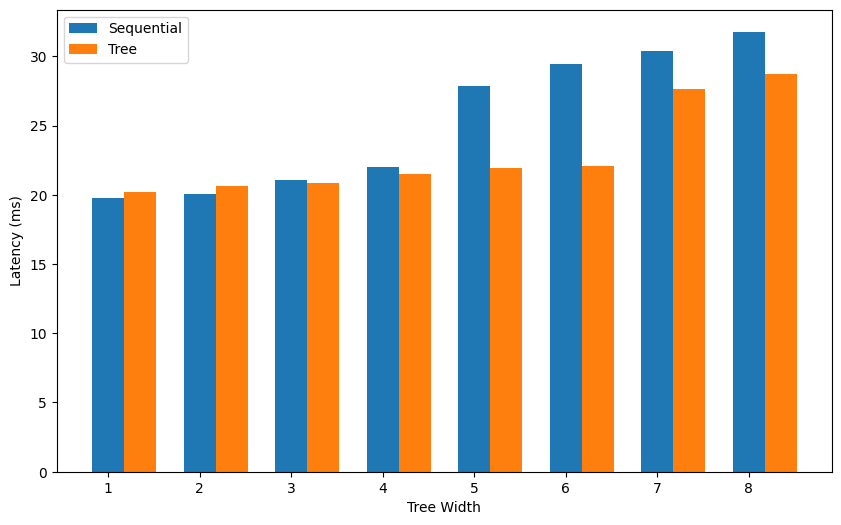

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
import numpy as np

width = 0.35
plt.figure(figsize=(10, 6))

x_data = tree_widths
y_sequential = np.array(sequential_times) * 1000 # scale to ms
plt.bar(x_data, y_sequential, label="Sequential", width=width)  # Plot the first list as the y-axis values
y_tree = np.array(tree_times) * 1000 # scale to ms
plt.bar([pos + width for pos in x_data], y_tree, label="Tree", width=width)  # Plot the second list as the y-axis values

plt.xlabel("Tree Width")
plt.ylabel("Latency (ms)")
plt.legend()

plt.show()
plt.savefig("tree_vs_sequential.png")

In [19]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 4.7 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 47.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 20.2 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 49.5 MB/s eta 0:00:00:00:0100:01
Using cached kiwisolver-1.4.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 7.8 MB/s eta 0:00:00
